In [1]:
!pip install creversi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.0/711.0 kB 3.3 MB/s eta 0:00:00


In [15]:
from creversi import *
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
k = 192
fcl_units = 256
class DQN(nn.Module):
  def __init__(self):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(2, k, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(k)
    self.conv2 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(k)
    self.conv3 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(k)
    self.conv4 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn4 = nn.BatchNorm2d(k)
    self.conv5 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn5 = nn.BatchNorm2d(k)
    self.conv6 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn6 = nn.BatchNorm2d(k)
    self.conv7 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn7 = nn.BatchNorm2d(k)
    self.conv8 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn8 = nn.BatchNorm2d(k)
    self.conv9 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn9 = nn.BatchNorm2d(k)
    self.conv10 = nn.Conv2d(k, k, kernel_size=3, padding=1)
    self.bn10 = nn.BatchNorm2d(k)
    self.fcl1 = nn.Linear(k * 64, fcl_units)
    self.fcl2 = nn.Linear(fcl_units, 65)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = F.relu(self.bn5(self.conv5(x)))
    x = F.relu(self.bn6(self.conv6(x)))
    x = F.relu(self.bn7(self.conv7(x)))
    x = F.relu(self.bn8(self.conv8(x)))
    x = F.relu(self.bn9(self.conv9(x)))
    x = F.relu(self.bn10(self.conv10(x)))
    x = F.relu(self.fcl1(x.view(-1, k * 64)))
    x = self.fcl2(x)
    return x.tanh()

In [3]:
class RandomPlayer:
    def go(self, board):
        legal_moves = board.legal_moves
        if len(legal_moves) == 0:
            return PASS
        else:
            return random.choice(list(legal_moves))

class GreedyPlayer:
    def __init__(self, model_path, device, network='dqn'):
        # if network == 'dueling':
        #     from creversi_gym.network.cnn10_dueling import DQN
        # else:
        #     #from creversi_gym.network.cnn5 import DQN
        #     from creversi_gym.network.cnn10 import DQN
        self.device = device
        self.model = DQN().to(device)
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.eval()
        self.features = np.empty((1, 2, 8, 8), np.float32)

    def go(self, board):
        with torch.no_grad():
            board.piece_planes(self.features[0])
            state = torch.from_numpy(self.features).to(self.device)
            q = self.model(state)
            # 合法手に絞る
            legal_moves = list(board.legal_moves)
            next_actions = torch.tensor([legal_moves], device=self.device, dtype=torch.long)
            legal_q = q.gather(1, next_actions)
            return legal_moves[legal_q.argmax(dim=1).item()]

In [4]:
def vs(board, player1, player2):
  player1name = player1.__class__.__name__
  player2name = player2.__class__.__name__
  print(player1name + " vs " + player2name)
  print(player1name + " Go First")
  while board.is_game_over() == False:
    board.move(player1.go(board))
    board.move(player2.go(board))
  n_white = 64 - board.piece_num()
  n_black = board.piece_num()
  if n_white > n_black:
    winner = 2
    print("White Win!")
  elif n_black > n_white:
    winner = 1
    print("Black Win!")
  else:
    winner = 0
    print("Draw!")
  print("White:",n_white)
  print("Black:",n_black)
  return board

def vs_notext(board, player1, player2):
  while board.is_game_over() == False:
    board.move(player1.go(board))
    board.move(player2.go(board))
  n_white = 64 - board.piece_num()
  n_black = board.piece_num()
  if n_white > n_black:
    winner = 2
  elif n_black > n_white:
    winner = 1
  else:
    winner = 0
  return winner

In [13]:
rp = RandomPlayer()
gp = GreedyPlayer("/content/epsilon_greedy_model.pt", device)

RandomPlayer vs GreedyPlayer
RandomPlayer Go First
Black Win!
White: 16
Black: 48


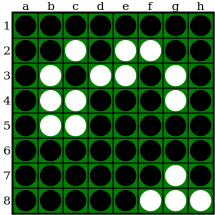

In [16]:
newboard = creversi.Board()
vs(newboard, rp, gp)

In [17]:
rpwin = 0
gpwin = 0
draw = 0
for i in range(500):
  board = creversi.Board()
  result = vs_notext(board, rp, gp)
  if result == 1:
    rpwin += 1
  elif result == 2:
    gpwin += 1
  else:
    draw += 1

  board = creversi.Board()
  result = vs_notext(board, gp, rp)
  if result == 1:
    gpwin += 1
  elif result == 2:
    rpwin += 1
  else:
    draw += 1

In [18]:
print("RandomPlayer vs GreedyPlayer")
print("RandomPlayer Win:", rpwin)
print("GreedyPlayer Win:", gpwin)
print("Draw:", draw)
print("RandomPlayer Win Rate:", rpwin/(rpwin+gpwin+draw))
print("GreedyPlayer Win Rate:", gpwin/(rpwin+gpwin+draw))

RandomPlayer vs GreedyPlayer
RandomPlayer Win: 406
GreedyPlayer Win: 544
Draw: 50
RandomPlayer Win Rate: 0.406
GreedyPlayer Win Rate: 0.544


In [19]:
rp1 = RandomPlayer()
rp2 = RandomPlayer()

rp1win = 0
rp2win = 0
draw = 0
for i in range(500):
  board = creversi.Board()
  result = vs_notext(board, rp1, rp2)
  if result == 1:
    rp1win += 1
  elif result == 2:
    rp2win += 1
  else:
    draw += 1

  board = creversi.Board()
  result = vs_notext(board, rp2, rp1)
  if result == 1:
    rp2win += 1
  elif result == 2:
    rp1win += 1
  else:
    draw += 1

In [20]:
print("RandomPlayer vs RandomPlayer")
print("RandomPlayer1 Win:", rp1win)
print("RandomPlayer2 Win:", rp2win)
print("Draw:", draw)
print("RandomPlayer1 Win Rate:", rp1win/(rp1win+rp2win+draw))
print("RandomPlayer2 Win Rate:", rp2win/(rp1win+rp2win+draw))

RandomPlayer vs RandomPlayer
RandomPlayer1 Win: 489
RandomPlayer2 Win: 478
Draw: 33
RandomPlayer1 Win Rate: 0.489
RandomPlayer2 Win Rate: 0.478


In [21]:
gp1 = GreedyPlayer("/content/epsilon_greedy_model.pt", device)
gp2 = GreedyPlayer("/content/epsilon_greedy_model.pt", device)

gp1win = 0
gp2win = 0
draw = 0
for i in range(500):
  board = creversi.Board()
  result = vs_notext(board, gp1, gp2)
  if result == 1:
    gp1win += 1
  elif result == 2:
    gp2win += 1
  else:
    draw += 1

  board = creversi.Board()
  result = vs_notext(board, gp2, gp1)
  if result == 1:
    gp2win += 1
  elif result == 2:
    gp1win += 1
  else:
    draw += 1

In [22]:
print("GreedyPlayer vs GreedyPlayer")
print("GreedyPlayer1 Win:", gp1win)
print("GreedyPlayer2 Win:", gp2win)
print("Draw:", draw)
print("GreedyPlayer1 Win Rate:", gp1win/(gp1win+gp2win+draw))
print("GreedyPlayer2 Win Rate:", gp2win/(gp1win+gp2win+draw))

GreedyPlayer vs GreedyPlayer
GreedyPlayer1 Win: 500
GreedyPlayer2 Win: 500
Draw: 0
GreedyPlayer1 Win Rate: 0.5
GreedyPlayer2 Win Rate: 0.5
